## Data Loading and Initial Setup

Here we import all necessary libraries and set up our development environment:
- Data manipulation: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine learning: scikit-learn, XGBoost
- Model tracking: MLflow

We'll use these libraries throughout the notebook for data processing, model training, and evaluation.

In [33]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique

# MLflow
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import inspect

# Scikit-learn preprocessing and pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc,
    precision_score, recall_score, f1_score
)

# Logging configuration
import logging
logging.getLogger("mlflow.models.model").setLevel(logging.ERROR)

# Warnings management
import warnings



In [2]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/mlruns


In [3]:
mlflow.set_experiment("Social Media Project Binary Classification")
mlflow.set_experiment_tag("scikit-learn", "lr")

2025/06/29 12:57:07 INFO mlflow.tracking.fluent: Experiment with name 'Social Media Project Binary Classification' does not exist. Creating a new experiment.


In [4]:
mlflow.set_tag("dataset", "social_sphere_v1")  

In [5]:
def log_model_run(
    model,                       # fitted estimator or pipeline
    params: dict,                # dict of hyper-parameters
    train_X, train_y,            # training data
    val_X,   val_y,              # validation data
    model_name: str = "Model",   # readable name for the run
    pos_label: int = 1,          # positive class
    experiment_name: str | None = None,   # optional: switch experiment
):
    """
    Generic MLflow run logger for binary-classification estimators that expose
    predict() and *optionally* predict_proba() / decision_function().
    """
    warnings.filterwarnings("ignore", message=".*Inferred schema contains integer column.*")

    # ------------------------------------------------------------------ #
    # 0) MLflow bookkeeping                                              #
    # ------------------------------------------------------------------ #
    if experiment_name:
        mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=model_name):
        # ----------------------- Hyper-parameters ---------------------- #
        mlflow.log_params(params)

        # ----------------------- Dataset lineage ---------------------- #
        mlflow.log_input(
            mlflow.data.from_pandas(train_X, name="train_v1"), context="training"
        )
        mlflow.log_input(
            mlflow.data.from_pandas(val_X,   name="val_v1"),   context="validation"
        )

        # ----------------------- Predictions -------------------------- #
        train_preds = model.predict(train_X)
        val_preds   = model.predict(val_X)

        # --- Probabilities or decision scores (needed for ROC/AUC) ---- #
        if hasattr(model, "predict_proba"):
            train_scores = model.predict_proba(train_X)[:, 1]   # pos class prob
            val_scores   = model.predict_proba(val_X)[:, 1]
        elif hasattr(model, "decision_function"):
            train_scores = model.decision_function(train_X)
            val_scores   = model.decision_function(val_X)
        else:   # fall-back: cannot compute ROC/AUC
            train_scores = val_scores = None

        # ----------------------- Metrics ------------------------------ #
        is_binary = len(set(train_y)) == 2
        avg_type = 'binary' if is_binary else 'macro'

        metrics = {
            "accuracy_train":  accuracy_score(train_y, train_preds),
            "precision_train": precision_score(train_y, train_preds, average=avg_type, pos_label=pos_label if is_binary else None),
            "recall_train":    recall_score(train_y, train_preds,   average=avg_type, pos_label=pos_label if is_binary else None),
            "f1_train":        f1_score(train_y, train_preds,       average=avg_type, pos_label=pos_label if is_binary else None),
            "accuracy_val":    accuracy_score(val_y, val_preds),
            "precision_val":   precision_score(val_y, val_preds,   average=avg_type, pos_label=pos_label if is_binary else None),
            "recall_val":      recall_score(val_y, val_preds,       average=avg_type, pos_label=pos_label if is_binary else None),
            "f1_val":          f1_score(val_y, val_preds,           average=avg_type, pos_label=pos_label if is_binary else None),
        }

        if is_binary and train_scores is not None:
            metrics["roc_auc_train"] = roc_auc_score(train_y, train_scores)
            metrics["roc_auc_val"]   = roc_auc_score(val_y,   val_scores)

        mlflow.log_metrics(metrics)

        # -------------------- Confusion matrices ---------------------- #
        for split, y_true, y_pred in [
            ("train", train_y, train_preds),
            ("val",   val_y,   val_preds)
        ]:
            cm = confusion_matrix(y_true, y_pred, labels=sorted(unique(train_y)))

            fig, ax = plt.subplots()
            ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap="Purples")
            ax.set_title(f"Confusion Matrix – {split.capitalize()}")

            mlflow.log_figure(fig, f"plots/conf_matrix_{split}.png")
            plt.close(fig)

        # -------------------- ROC curves (if available) --------------- #
        if train_scores is not None and is_binary:
            for split, y_true, y_score, auc in [
                ("train", train_y, train_scores, metrics["roc_auc_train"]),
                ("val",   val_y,   val_scores,   metrics["roc_auc_val"])
            ]:
                fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label)

                fig, ax = plt.subplots()
                ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
                ax.plot([0, 1], [0, 1], "k--")
                ax.set_xlabel("False Positive Rate")
                ax.set_ylabel("True Positive Rate")
                ax.set_title(f"ROC Curve – {split.capitalize()}")
                ax.legend()

                mlflow.log_figure(fig, f"plots/roc_curve_{split}.png")
                plt.close(fig)

        # -------------------- Model itself ---------------------------- #
        # Detect the correct MLflow flavour (simple heuristic)
        if "sklearn" in inspect.getmodule(model).__name__:
            mlflow.sklearn.log_model(
                model,
                name=f"{model_name.lower().replace(' ', '_')}_pipeline",
                input_example=val_X.iloc[:1].copy(),
                signature=infer_signature(train_X, train_preds),
                registered_model_name=model_name
            )
        else:
            # fall-back = log as generic pyfunc
            mlflow.pyfunc.log_model(
                name=f"{model_name.lower().replace(' ', '_')}_model",
                python_model=model,
                registered_model_name=model_name
            )

        # --------------- return metrics for convenience --------------- #
        return metrics

In [6]:
df = pd.read_csv('data.csv') 

## Feature Engineering and Preprocessing

In this section, we:
1. Create a binary target variable for conflicts over social media (High/Low)
2. Handle country information by grouping less frequent countries
3. Separate features into numeric and categorical columns
4. Set up preprocessing pipelines for both types of features:
   - Numeric features: StandardScaler
   - Categorical features: OneHotEncoder

We'll exclude certain columns that shouldn't be used as features (e.g., IDs and target-related columns).

In [7]:
df["Conflicts_Over_Social_Media_Binary"] = df["Conflicts_Over_Social_Media"].apply(lambda x: 0 if x <= 2 else 1).astype(int)


Text(0, 0.5, 'Count')

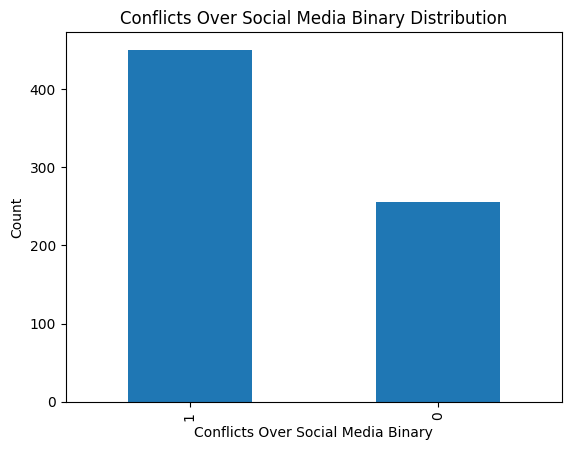

In [8]:
df["Conflicts_Over_Social_Media_Binary"].value_counts().plot(kind='bar', title='Conflicts Over Social Media Binary Distribution')
plt.xlabel('Conflicts Over Social Media Binary')
plt.ylabel('Count')

In [9]:
country_counts = df['Country'].value_counts()
df['country_grouped'] = df['Country'].apply(lambda x: x if country_counts[x] > 1 else 'Other')

In [10]:
df.head()

Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationship_Status  Conflicts_Over_Social_Media  \
0                    6     In Relationship                            3   
1                    8              Single                            0   
2                    5         Complicated                            4   
3                    7              Single                            1   
4                    6     In Relationship                            2   

   Addicted_Score  Conflicts_Over_Social_Media_Binary country_grouped  
0               8                                   1      Bangladesh  
1               3                                   0           India  
2               9                                   1             USA  
3               4                                   0              UK  
4               7                                   0          Canada

In [11]:
exclude_cols = ['Student_ID', 'Conflicts_Over_Social_Media', 'Country', 'Conflicts_Over_Social_Media_Binary', 'Addicted_Score', 'Affects_Academic_Performance'] 
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score']


In [12]:
categoric_cols = df.select_dtypes(include='object').columns
categoric_cols = [col for col in categoric_cols if col not in exclude_cols]
print(categoric_cols)

['Gender', 'Academic_Level', 'Most_Used_Platform', 'Relationship_Status', 'country_grouped']


In [13]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Conflicts_Over_Social_Media_Binary'])

## Model Development

### Data Split and Pipeline Setup
We split our data into training and validation sets with a 80-20 split ratio. For the models, we:
1. Create preprocessing pipelines that combine numeric and categorical transformers
2. Set up model hyperparameters
3. Create full pipelines that combine preprocessing and model training
4. Train the models and make predictions

We'll implement two models:
1. Logistic Regression - as a baseline model
2. XGBoost - as our main model

In [38]:
input_cols = numeric_cols + categoric_cols
target_col = 'Conflicts_Over_Social_Media_Binary'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [39]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [40]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [41]:
lr_params = {
    "solver": "liblinear",
    "class_weight":'balanced',
    "C": 0.1, 
    "max_iter": 1000,
    "random_state": 42,
}

In [42]:
# Define preprocessing and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categoric_cols)]
)

# Create a more robust model with adjusted hyperparameters
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**lr_params)) 
])

# Fit the model and get predictions to check class balance
lr_pipeline.fit(train_inputs, train_targets)
train_preds = lr_pipeline.predict(train_inputs)
val_preds = lr_pipeline.predict(val_inputs)

##  Model Evaluation and MLflow Tracking

#### Logistic Regression

In [43]:
mlflow.end_run()

In [44]:
log_model_run(
    model=lr_pipeline,
    params=lr_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="Logistic Regression without Affects on Academic Performance")

Registered model 'Logistic Regression without Affects on Academic Performance' already exists. Creating a new version of this model...
Created version '7' of model 'Logistic Regression without Affects on Academic Performance'.


{'accuracy_train': 0.9946808510638298,
 'precision_train': 0.9944598337950139,
 'recall_train': 0.9972222222222222,
 'f1_train': 0.9958391123439667,
 'accuracy_val': 0.9929078014184397,
 'precision_val': 0.989010989010989,
 'recall_val': 1.0,
 'f1_val': 0.994475138121547,
 'roc_auc_train': 0.997140522875817,
 'roc_auc_val': 0.9910675381263616}

#### XGBoost

In [45]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

In [46]:
xgb_params = {
    "max_depth": 3,
    "n_estimators": 10,
    "enable_categorical": True,
    "random_state": 42
}


xgb = XGBClassifier(
        ** xgb_params,
     ).fit(train_inputs, train_targets)



log_model_run(
    model=xgb,
    params=xgb_params,
    train_X=train_inputs, train_y=train_targets,
    val_X=val_inputs,     val_y=val_targets,
    model_name="XGBoost"
)

Registered model 'XGBoost' already exists. Creating a new version of this model...
Created version '13' of model 'XGBoost'.


{'accuracy_train': 0.9964539007092199,
 'precision_train': 0.994475138121547,
 'recall_train': 1.0,
 'f1_train': 0.997229916897507,
 'accuracy_val': 0.9929078014184397,
 'precision_val': 0.989010989010989,
 'recall_val': 1.0,
 'f1_val': 0.994475138121547,
 'roc_auc_train': 0.9994893790849674,
 'roc_auc_val': 0.9979302832244008}

### Multiclass Classification. One versus Rest Classifier. 

##### Preprocessing

In [47]:
exclude_cols = ['Student_ID', 'Conflicts_Over_Social_Media', 'Country', 'Conflicts_Over_Social_Media_Binary'] 
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
print(numeric_cols)

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Addicted_Score']


In [48]:
categoric_cols = df.select_dtypes(include='object').columns
categoric_cols = [col for col in categoric_cols if col not in exclude_cols]
print(categoric_cols)

['Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status', 'country_grouped']


In [49]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Conflicts_Over_Social_Media'])

In [50]:
input_cols = numeric_cols + categoric_cols
target_col = 'Conflicts_Over_Social_Media'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [51]:
print(train_inputs.columns.tolist())

['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Addicted_Score', 'Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status', 'country_grouped']


In [52]:
mlflow.set_experiment("Social Media Project Multiclass Classification")
mlflow.set_experiment_tag("scikit-learn", "ovr_svc")

In [53]:
# 1. Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2. Define column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categoric_cols)
])

# 3. Define hyperparameters
model_params = {
    "C": 1.0,
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42
}

# 4. Initialize base classifier with params
base_clf = LinearSVC(**model_params)
ovr_clf = OneVsRestClassifier(base_clf)

# 5. Build full pipeline
ovr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ovr_clf)
])

# 6. Fit and predict
ovr_pipeline.fit(train_inputs, train_targets)
train_preds = ovr_pipeline.predict(train_inputs)
val_preds = ovr_pipeline.predict(val_inputs)

# 7. Define logging params (optional extra metadata)
log_params = {
    **model_params,
    "model_type": "OneVsRestClassifier",
    "base_model": "LinearSVC"
}
log_model_run(
    model=ovr_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass LinearSVC One-vs-Rest",
    params=log_params
)

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Registered model 'Multiclass LinearSVC One-vs-Rest' already exists. Creating a new version of this model...
Created version '5' of model 'Multiclass LinearSVC One-vs-Rest'.


{'accuracy_train': 0.9769503546099291,
 'precision_train': 0.9485799288430866,
 'recall_train': 0.8806293855924155,
 'f1_train': 0.9078855675061458,
 'accuracy_val': 0.9716312056737588,
 'precision_val': 0.8029754904467284,
 'recall_val': 0.7551942186088527,
 'f1_val': 0.7734817214033978}

In [54]:
mlflow.set_experiment_tag("scikit-learn", "LinearSVC")

In [55]:
# Define hyperparameters
model_params = {
    "C": 1.0,
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42
}

# Initialize LinearSVC directly
svc_clf = LinearSVC(**model_params)

# Build full pipeline
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc_clf)
])

# Fit the pipeline
svc_pipeline.fit(train_inputs, train_targets)

# Define logging params
log_params = {
    **model_params,
    "model_type": "LinearSVC",
    "multiclass_strategy": "ovr"
}

# Log the model run
log_model_run(
    model=svc_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass LinearSVC One-vs-Rest",
    params=log_params
)

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Registered model 'Multiclass LinearSVC One-vs-Rest' already exists. Creating a new version of this model...
Created version '6' of model 'Multiclass LinearSVC One-vs-Rest'.


{'accuracy_train': 0.9840425531914894,
 'precision_train': 0.9626651242232461,
 'recall_train': 0.936184941147971,
 'f1_train': 0.9428326433226538,
 'accuracy_val': 0.9787234042553191,
 'precision_val': 0.807605120076358,
 'recall_val': 0.8107497741644082,
 'f1_val': 0.8091624725771066}

In [56]:
mlflow.set_experiment_tag("scikit-learn", "log_reg_multinomial")

In [57]:
# Define hyperparameters
model_params = {
    "C": 1.0,
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42,
    "multi_class": "multinomial"  # or "ovr"
}

# Initialize LogisticRegression
lr_clf = LogisticRegression(**model_params)

# 5Build full pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_clf)
])

# Fit the pipeline
lr_pipeline.fit(train_inputs, train_targets)

# 7Define logging params
log_params = {
    **model_params,
    "model_type": "LogisticRegression"
}

# Log the model run
log_model_run(
    model=lr_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass LogisticRegression Multinomial",
    params=log_params
)

c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Registered model 'Multiclass LogisticRegression Multinomial' already exists. Creating a new version of this model...
Created version '2' of model 'Multiclass LogisticRegression Multinomial'.


{'accuracy_train': 0.9804964539007093,
 'precision_train': 0.9579912134525072,
 'recall_train': 0.9884964661610893,
 'f1_train': 0.9720536638663321,
 'accuracy_val': 0.9716312056737588,
 'precision_val': 0.959248508305112,
 'recall_val': 0.9692863595302619,
 'f1_val': 0.9637635756056809}

### Multiclass Classification. One versus One Classifier. 

In [58]:
mlflow.set_experiment_tag("scikit-learn", "svc_ovo")

In [59]:
# Define hyperparameters for SVC
model_params = {
    "kernel": "linear",  # Makes it equivalent to LinearSVC
    "C": 1.0,
    "class_weight": "balanced",
    "random_state": 42,
    "decision_function_shape": "ovo"  # One-vs-One
}

# Initialize SVC with one-vs-one
svc_ovo_clf = SVC(**model_params)

# Build full pipeline
svc_ovo_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc_ovo_clf)
])

# Fit the pipeline
svc_ovo_pipeline.fit(train_inputs, train_targets)

# Define logging params
log_params = {
    **model_params,
    "model_type": "SVC",
    "multiclass_strategy": "ovo"
}

# Log the model run
log_model_run(
    model=svc_ovo_pipeline,
    train_X=train_inputs,
    train_y=train_targets,
    val_X=val_inputs,
    val_y=val_targets,
    model_name="Multiclass SVC One-vs-One",
    params=log_params
)

Registered model 'Multiclass SVC One-vs-One' already exists. Creating a new version of this model...
Created version '2' of model 'Multiclass SVC One-vs-One'.


{'accuracy_train': 0.9804964539007093,
 'precision_train': 0.9649757748162004,
 'recall_train': 0.9890746046424668,
 'f1_train': 0.9763051701495945,
 'accuracy_val': 0.9929078014184397,
 'precision_val': 0.9953703703703703,
 'recall_val': 0.9959349593495935,
 'f1_val': 0.9955949689909002}